In [189]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import PIL
from tensorflow.keras import layers
import time
from IPython import display

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    except RuntimeError as e:
        print(e)

In [190]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [191]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [192]:
def make_generator_model():
    z_input= tf.keras.layers.Input(shape = (100,))
    y_input= tf.keras.layers.Input(shape = (10,))
    hidden_input = tf.keras.layers.Concatenate(axis=-1)([z_input, y_input])
    x = layers.Dense(7*7*256, use_bias=False)(hidden_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model(inputs = [z_input, y_input] , outputs = x)

def make_discriminator_model():
    image_input= tf.keras.layers.Input(shape = (28,28,1,))
    y_input= tf.keras.layers.Input(shape = (10,))

    x_input = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x_input = layers.LeakyReLU()(x_input)
    x_input = layers.Dropout(0.3)(x_input)
    
    label_input = layers.Lambda(expand_label_input)(y_input)
    
    hidden_input = tf.keras.layers.Concatenate(axis=-1)([x_input, label_input])

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(hidden_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.Model(inputs = [image_input, y_input] , outputs = x)

def expand_label_input(x):
    x = tf.expand_dims(x, axis =1)
    x = tf.expand_dims(x, axis =1)
    x = tf.tile(x, [1,14,14,1])
    return x

In [193]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [194]:
mse = tf.losses.MeanSquaredError()

def d_loss(r_logit, f_logit):
    r_loss = mse(tf.ones_like(r_logit), r_logit)
    f_loss = mse(tf.zeros_like(f_logit), f_logit)
    return r_loss + f_loss

def g_loss(f_logit):
    f_loss = mse(tf.ones_like(f_logit), f_logit)
    return f_loss

In [195]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

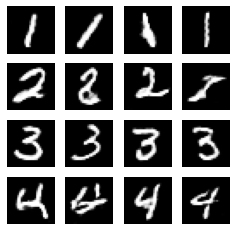

In [212]:
noise = tf.random.normal([16, 100])
label = tf.one_hot([1,1,1,1,
                    2,2,2,2,
                    3,3,3,3,
                    4,4,4,4], 10)
seed = [noise, label]
generated_images(generator, 1, seed)

In [197]:
@tf.function
def train_step(image, label):
    noise = tf.random.normal([image.shape[0], 100])
    label = tf.one_hot(label, 10)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_image = generator([noise,label], training=True)
        
        real_output = discriminator([image, label], training=True)
        fake_output = discriminator([gen_image, label], training=True)
        
        gen_loss = g_loss(fake_output)
        disc_loss = d_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return disc_loss, gen_loss

In [198]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        d_loss, g_loss = 0, 0
        for image_batch, label_batch in dataset:
            loss = train_step(image_batch, label_batch)
            d_loss += loss[0]
            g_loss += loss[1]
            
        display.clear_output(wait=True)
        generated_images(generator, epoch+1, seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print('D loss : ',d_loss.numpy()/BATCH_SIZE, 'G loss :',g_loss.numpy()/BATCH_SIZE)

def generated_images(generator, epoch, seed):
    images = generator(seed, training = False)
    fig = plt.figure(figsize=(4,4))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()    

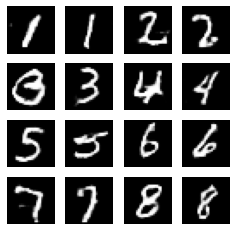

Time for epoch 50 is 8.113420009613037 sec
D loss :  1.7239363193511963 G loss : 1.1096699237823486
CPU times: user 2min 31s, sys: 9.12 s, total: 2min 40s
Wall time: 6min 47s


In [203]:
%%time
train(train_dataset, 50)